Linear Regression Model Performance:
Mean RMSE: 0.09
Standard deviation RMSE: 0.00
Test Set Performance:
Linear Regression:
Mean Absolute Error: 0.07
Mean Squared Error: 0.01
Root Mean Squared Error: 0.10


<ipython-input-1-da8351982960>:69: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week_of_year'] = data.index.weekofyear


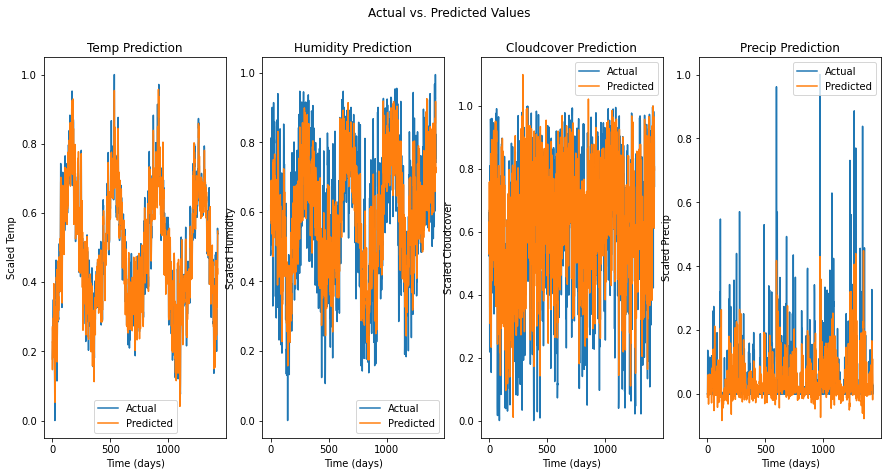

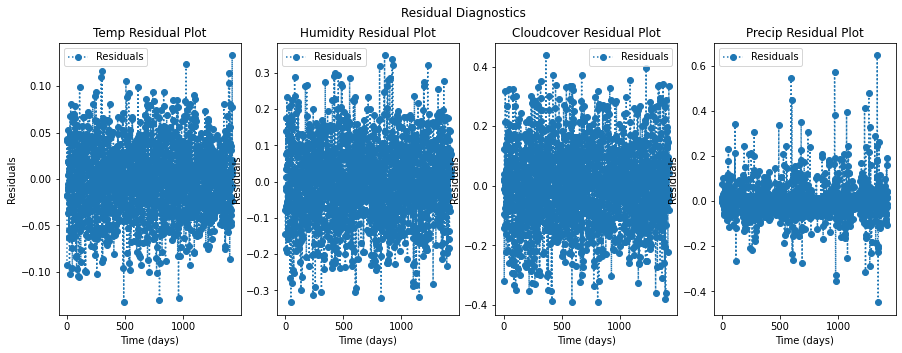

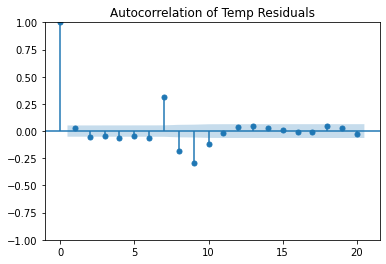

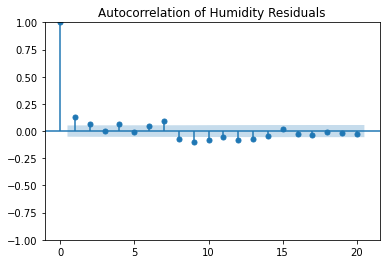

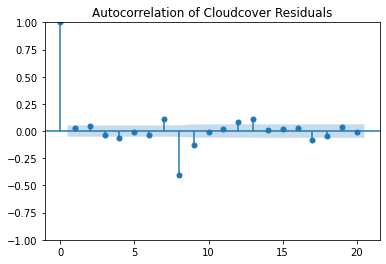

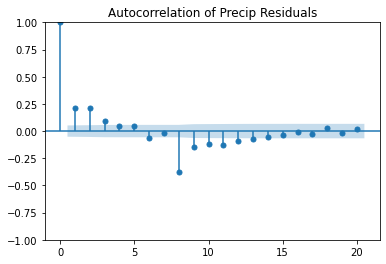

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore

# Load the data
data = pd.read_csv('/data/notebook_files/london_dataset.csv')

# Convert the 'datetime' column to datetime data type
data['datetime'] = pd.to_datetime(data['datetime'])

# Sort the data by date
data.sort_values(by=['datetime'], inplace=True)

# Set the 'datetime' column as the index
data.set_index('datetime', inplace=True)

# Create lag features
def create_lag_features(df, lag_features, n_lags):
    df = df.copy()
    for feature in lag_features:
        for lag in range(1, n_lags+1):
            df[f"{feature}_lag{lag}"] = df[feature].shift(lag)
    return df

# Create lag features for temperature, humidity, cloud cover and precip
n_lags = 7
data = create_lag_features(data, ['temp', 'humidity', 'cloudcover', 'precip'], n_lags)
# Define the target variable and feature set from dataset
target = ['temp', 'humidity', 'cloudcover','precip']

# Add rolling window features for temperature, humidity, cloud cover, and precip
# Window sizes for each weather varaible differ according to their time-series characteristics (i.e. seasonality, stationality, trend, residuals) and from experimental anlaysis
data['rolling_mean_temp_90'] = data['temp'].rolling(window=90).mean() #90 day window
data['rolling_mean_temp_30'] = data['temp'].rolling(window=30).mean() #30 day window
data['rolling_mean_temp_14'] = data['temp'].rolling(window=14).mean() #14 day window
data['rolling_mean_temp_9'] = data['temp'].rolling(window=9).mean() #9 day window
data['rolling_mean_humidity_30'] = data['humidity'].rolling(window=30).mean()
data['rolling_mean_humidity_14'] = data['humidity'].rolling(window=14).mean()
data['rolling_mean_cloudcover_14'] = data['cloudcover'].rolling(window=14).mean()
data['rolling_mean_cloudcover_9'] = data['cloudcover'].rolling(window=9).mean()
data['rolling_mean_precip_14'] = data['precip'].rolling(window=14).mean()
#data['rolling_mean_precip_10'] = data['precip'].rolling(window=9).mean()
data['rolling_std_temp_90'] = data['temp'].rolling(window=90).std()
data['rolling_std_temp_0'] = data['temp'].rolling(window=30).std()
data['rolling_std_temp_14'] = data['temp'].rolling(window=14).std()
data['rolling_std_temp_9'] = data['temp'].rolling(window=9).std()
data['rolling_std_humidity_30'] = data['humidity'].rolling(window=30).std()
data['rolling_std_humidity_14'] = data['humidity'].rolling(window=14).std()
data['rolling_std_cloudcover_14'] = data['cloudcover'].rolling(window=14).std()
data['rolling_std_cloudcover_9'] = data['cloudcover'].rolling(window=9).std()
data['rolling_std_precip_14'] = data['precip'].rolling(window=14).std()
data['rolling_std_precip_9'] = data['precip'].rolling(window=9).std()

# Add date-related features
data['day_of_week'] = data.index.dayofweek
data['day_of_month'] = data.index.day
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['day_of_year'] = data.index.dayofyear
data['week_of_year'] = data.index.weekofyear


# Get the list of column names in the dataframe
all_features = data.columns.tolist()

# Filter the list to include only the relevant features
lag_features = [f"{variable}_lag{i}" for variable in target for i in range(1, n_lags+1)]
rolling_mean_features = [f"rolling_mean_{variable}_{window}" for variable in target for window in [7, 9, 10, 14, 30, 90]]
rolling_std_features = [f"rolling_std_{variable}_{window}" for variable in target for window in [7, 9, 10, 14, 30, 90]]
date_features = ['day_of_week', 'day_of_month', 'month', 'quarter', 'day_of_year', 'week_of_year']
features = lag_features + rolling_mean_features + rolling_std_features + date_features

# Drop rows with NaN values created by lag features and rolling window features
nan_columns = [f"{feature}_lag{i}" for feature in target for i in range(1, n_lags+1)] 
nan_columns += [f"rolling_mean_{feature}_{window}" for feature in target for window in [90, 30, 14, 10, 9, 7]]
nan_columns += [f"rolling_std_{feature}_{window}" for feature in target for window in [90, 30, 14, 10, 10, 7]]

# Filter the nan_columns list to only include columns that are present in the data
nan_columns = list(filter(lambda x: x in data.columns, nan_columns))

data.dropna(subset=nan_columns, inplace=True)


# Filter the list to include only the features that are present in the dataframe
features = list(set(features) & set(all_features))

X = data[features]
y = data[target]


# Scale the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
scores = cross_val_score(lr_model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print("Linear Regression Model Performance:")
print(f"Mean RMSE: {rmse_scores.mean():.2f}")
print(f"Standard deviation RMSE: {rmse_scores.std():.2f}")

# Make predictions on the test set using the best model and evaluate the model's performance
y_pred_lr = lr_model.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = sqrt(mse_lr)

print("Test Set Performance:")
print("Linear Regression:")
print(f"Mean Absolute Error: {mae_lr:.2f}")
print(f"Mean Squared Error: {mse_lr:.2f}")
print(f"Root Mean Squared Error: {rmse_lr:.2f}")

# Add plotting of actual vs. predicted values for each variable
plt.figure(figsize=(15, 7)) # Increase the figure size

for i, variable in enumerate(target):
    plt.subplot(1, 4, i+1)
    plt.plot(y_test[:,i], label='Actual')
    plt.plot(y_pred_lr[:,i], label='Predicted')
    plt.title(f"{variable.capitalize()} Prediction")
    plt.xlabel('Time (days)')
    plt.ylabel(f'Scaled {variable.capitalize()}')
    plt.legend()

plt.suptitle('Actual vs. Predicted Values')
plt.show()

# Residual diagnostics
residuals_lr = y_test - y_pred_lr

plt.figure(figsize=(15, 5))
for i, variable in enumerate(target):
    plt.subplot(1, 4, i+1)
    plt.plot(residuals_lr[:,i], label='Residuals', linestyle=':', marker='o')
    plt.xlabel('Time (days)')
    plt.ylabel('Residuals')
    plt.title(f"{variable.capitalize()} Residual Plot")
    plt.legend()

plt.suptitle('Residual Diagnostics')
plt.show()

# Autocorrelation plot of residuals
for i, variable in enumerate(target):
    plot_acf(residuals_lr[:,i], lags=20)
    plt.title(f"Autocorrelation of {variable.capitalize()} Residuals")
plt.show()